# Discharge data analysis

In this notebook, we're looking at discharge data for different batteries to get a better feeling of how such a system behaves.

In [1]:
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
root_battery_data = "./analyzed_dataset"

battery_dirs = [
    "B0005",
    "B0006",
    "B0007",
    "B0018"
]

In [43]:
from typing import Dict
import os

"""The functions below allow us to work with a dict with such structure:
  {
    "battery_name1": {
      "dataset_number1" : dataset_as_DataFrame,
      "dataset_number2" : dataset_as_DataFrame,
      ...
      "dataset_number3" : dataset_as_DataFrame
    },
    ...,
    "battery_nameN": {
      "dataset_numberX" : dataset_as_DataFrame,
      "dataset_numberY" : dataset_as_DataFrame,
      ...
      "dataset_numberZ" : dataset_as_DataFrame
    }
  }
"""

def get_battery_discharge_dir(dir_root, battery_dir):
    return dir_root + "/" + battery_dir + "/discharge/"

def get_battery_datasets(battery_discharge_dir):
    datasets = {}
    for filename in os.listdir(battery_discharge_dir):
        index = os.path.splitext(filename)[0]
        filepath = battery_discharge_dir + filename
        datasets[index] = pd.read_csv(filepath)

    return datasets

def get_all_batteries_with_datasets(dir_root, batteries):
    battery_datasets = {}

    for battery in batteries:
        battery_datasets[battery] = get_battery_datasets(get_battery_discharge_dir(dir_root, battery))
    
    return battery_datasets

In [42]:
battery_datasets = get_all_batteries_with_datasets(root_battery_data, battery_dirs)

B0005
B0006
B0007
B0018


In [45]:
"""Quick visualisation of the data dictionary we're using"""
for battery in battery_datasets.keys():
    for dataset in battery_datasets[battery].keys():
        print(f"battery: {battery} dataset:{dataset} data:\n{battery_datasets[battery][dataset].head(2)}\n")

battery: B0005 dataset:05302 data:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.198342         -0.002335             23.971566        0.0006   
1          4.197871         -0.001720             23.979122        0.0008   

   Voltage_load  Time  
0         0.000  0.00  
1         4.213  9.39  

battery: B0005 dataset:05230 data:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.199185          0.000082             23.757591        0.0006   
1          4.198650          0.001152             23.755162        0.0006   

   Voltage_load  Time  
0         0.000  0.00  
1         4.215  9.36  

battery: B0005 dataset:05613 data:
   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.195756         -0.006175             24.030138        0.0006   
1          4.195184         -0.000889             24.032099        0.0006   

   Voltage_load   Time  
0         0.000  0.000  
1  

In [47]:
battery_dataset_sizes = {}
for battery in battery_datasets.keys():
    battery_dataset_size = 0
    for dataset in battery_datasets[battery].keys():
        battery_dataset_size += battery_datasets[battery][dataset].size
    battery_dataset_sizes[battery] = battery_dataset_size

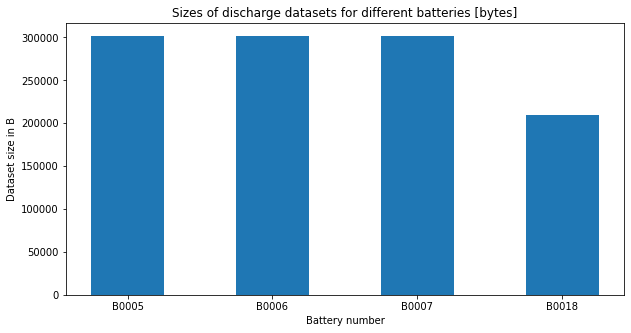

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(battery_dataset_sizes.keys(), battery_dataset_sizes.values(), 0.5)
ax.set_title("Sizes of discharge datasets for different batteries [bytes]")
ax.set_xlabel("Battery number")
ax.set_ylabel("Dataset size in B")
plt.show()

## Sample discharge dataset visualisation and analysis

In [102]:
df = battery_datasets["B0005"]["05122"]
df.columns

Index(['Voltage_measured', 'Current_measured', 'Temperature_measured',
       'Current_load', 'Voltage_load', 'Time'],
      dtype='object')

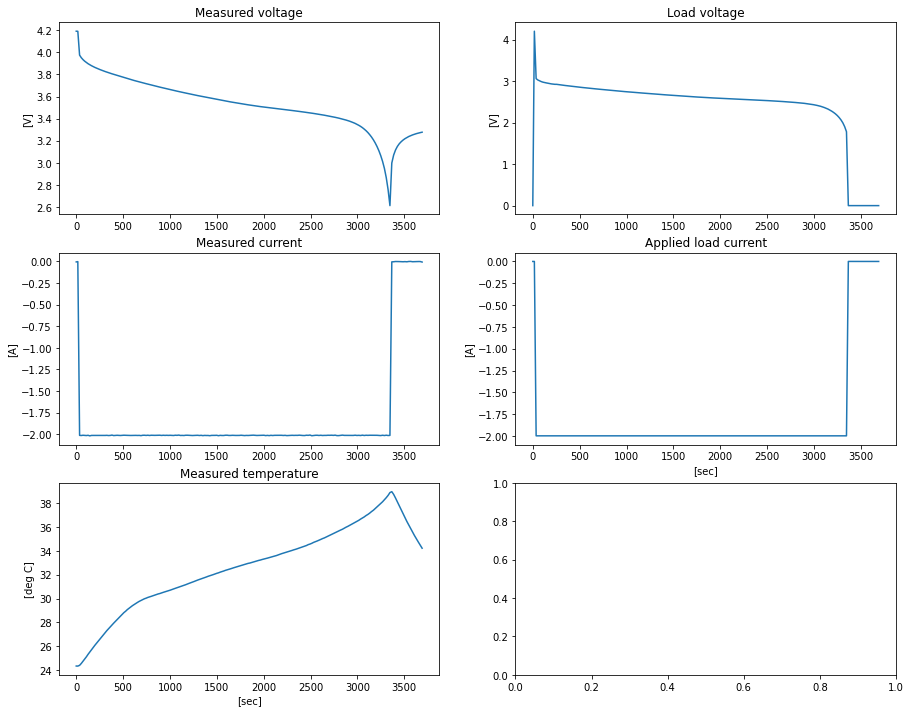

In [103]:
time = df["Time"]

v_meas = df["Voltage_measured"].to_numpy()
i_meas = df["Current_measured"].to_numpy()
t_meas = df["Temperature_measured"].to_numpy()
v_load = df["Voltage_load"].to_numpy()
i_load = df["Current_load"].to_numpy()

fig, ax = plt.subplots(3, 2, figsize=(15, 12))
ax[0,0].plot(time, v_meas)
ax[0,0].set_title("Measured voltage")
ax[0,0].set_ylabel("[V]")
ax[1,0].plot(time, i_meas)
ax[1,0].set_title("Measured current")
ax[1,0].set_ylabel("[A]")
ax[2,0].plot(time, t_meas)
ax[2,0].set_title("Measured temperature")
ax[2,0].set_ylabel("[deg C]")
ax[0,1].plot(time, v_load)
ax[0,1].set_title("Load voltage")
ax[0,1].set_ylabel("[V]")
ax[1,1].plot(time, i_load)
ax[1,1].set_title("Applied load current")
ax[1,1].set_ylabel("[A]")
ax[2,0].set_xlabel("[sec]")
ax[1,1].set_xlabel("[sec]")
fig.align_xlabels(ax)

plt.show()

After plotting a sample discharge dataset we can observe that the applied current was equal to 2A, as described in the dataset description. The cell was discharged from 4.2[V] to around 2.7[V].

We can use the theoretical formula (Coulomb Counting) for SoC to estimate the theoretical value of this cells charge. To do this, we need to know the initial capacity which is 2[Ah], according to dataset description. We can also find that the discharge capacity should be equal to 1.7158065389330133[Ah]

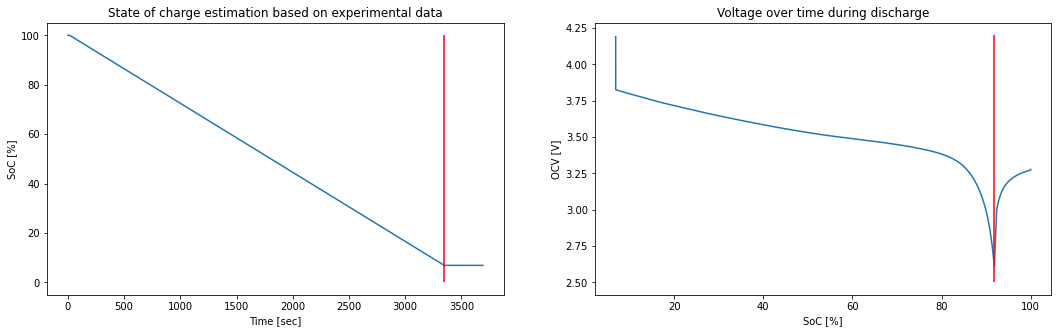

In [105]:
soc = np.ones_like(i_meas) # we're starting with SoC equal to 1.0, so 100%
Q_0 = 2 * 3600 # Asec -> because we're going to use seconds as the base, 1Ah = 1A * 3600sec = 3600Asec
idx_at_cap_meas = None

# iterative implementation of coulomb counting
for i in range(1, len(i_meas)):
    dt = time[i] - time[i - 1]
    soc[i] = soc[i - 1] + (i_meas[i]/Q_0) * dt
    if (v_meas[i] - 2.7) < 0.2:
        idx_at_cap_meas = i

soc_percentage = soc * 100.0

soc_percentage_flipped = np.flip(soc_percentage)

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ax[0].plot(time, soc_percentage)
ax[0].vlines(time[idx_at_cap_meas], 0, 100, colors="red")
ax[0].set_title("State of charge estimation based on experimental data")
ax[0].set_ylabel("SoC [%]")
ax[0].set_xlabel("Time [sec]")
ax[1].plot(soc_percentage_flipped, v_meas)
ax[1].vlines(soc_percentage_flipped[idx_at_cap_meas], 2.5, 4.2, colors="red")
ax[1].set_title("Voltage over time during discharge")
ax[1].set_ylabel("OCV [V]")
ax[1].set_xlabel("SoC [%]")

plt.show()

In [98]:
soc_final = soc[idx_at_cap_meas]

measured_discharge_capacity = 1.8564874208181574
estimated_discharge_capacity = (1-soc_final) * (Q_0 / 3600)

print(f"discharge capacity\nmeasured: {measured_discharge_capacity}\nestimated: {estimated_discharge_capacity}")

discharge capacity
measured: 1.7158065389330133
estimated: 1.7186364156078433
